# Построение модели для распознавания типа мусора

## Решение задачи CV по распознаванию изображений

Загрузим в проект необходимые модули, функционал которых мы будем использовать в дальнейшем.

In [1]:
import warnings
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from sklearn.metrics import balanced_accuracy_score

Модуль warnings используется для отключения всплывающих предупреждений, модуль os используется для комфортного взаимодействия с локальной машиной, модуль numpy предоставляет качественные оптимизированные многомерные массивы, модуль matplotlib предоставляет функционал для визуализации данных, модуль torch предоставляет функционал для работы с нейронными сетями, модуль torchvision - предоставляет функционал для работы с нейронными сетями в области компьютерного зрения, модуль sklearn (scikit-learn) предоставляет объёмный функционал для решения задач машинного обучения.

Взглянём на классы, которые имеются в нашем распоряжении.

In [2]:
data_dir  = 'C://Garbage_classification'
classes = os.listdir(data_dir)
print(classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


Итого имеется: картон, стекло, метал, бумага, пластик и прочий мусор.

Зададим преобразования: каждое изображение необходимо привести к размеру 256x256 и к формату Torch Tensor, после чего создадим генератор, в который поместим все наши изображения. К каждому изображению будут применены указанные преобразования.

In [3]:
predtrans = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
data = ImageFolder(data_dir, transform=predtrans)

Выведем случайно выбранное изображение на экран.

Class label: glass
Class number: 1


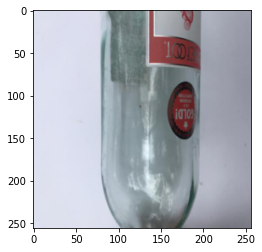

In [4]:
def show_image(img, classlabel):
    print('Class label:', data.classes[classlabel])
    print('Class number: ' + str(classlabel))
    plt.imshow(img.permute(1, 2, 0))
    plt.show()

img, classlabel = data[777]
show_image(img, classlabel)

Разобьём данные на обучающую выборку, валидационную выборку и тестовую выборку.

In [5]:
train_data, val_data, test_data = random_split(data, [2021, 406, 100])

Создадим генератор, передающий данные в модель: отдельно для обучающей и для валидационной выборки. Разбер батча установим 32.

In [6]:
batch_size = 32
train_dataloader = DataLoader(train_data, batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size)

Выведем на экран случайный батч.

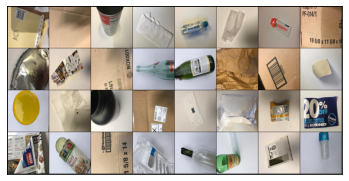

In [7]:
def show_batch(batch):
    for images, classlabels in batch:
        fig, ax = plt.subplots()
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        plt.show()
        break
show_batch(train_dataloader)

В своей работе я буду использовать нейронную сеть архитектуры ResNet с 50 слоями глубины. Также задам метрику точности на основе balanced accuracy из scikit-learn, поскольку классы несбалансированы.

In [8]:
def accuracy(Y_pred, Y_true):
    _, predlabels = torch.max(Y_pred, dim=1)
    return torch.tensor(balanced_accuracy_score(Y_true.numpy(), predlabels.numpy()))

class ModelBase(nn.Module):
    def train_step(self, batch):
        images, labels = batch
        preds = self(images)
        loss = F.cross_entropy(preds, labels)
        return loss

    def validate_step(self, batch):
        images, labels = batch
        preds = self(images)
        loss = F.cross_entropy(preds, labels)
        acc = accuracy(preds, labels)
        return {"val_loss": loss.detach(), "val_acc": acc}

    def validate_epoch(self, results):
        losses = [i['val_loss'] for i in results]
        accuracies = [i['val_acc'] for i in results]
        epoch_loss = torch.stack(losses).mean()
        epoch_acc = torch.stack(accuracies).mean()
        return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch + 1, result['train_loss'], result['val_loss'], result['val_acc']))


class ResNet50(ModelBase):
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet50(pretrained=True)
        last_input = self.model.fc.in_features
        self.model.fc = nn.Linear(last_input, len(data.classes))

    def forward(self, x):
        return torch.softmax(self.model(x), dim=1)

model = ResNet50()

D:\Anaconda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Anaconda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Также я задам возможность переключения на GPU, если таковая возможность имеется.

In [9]:
def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(i, device) for i in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device

    def __iter__(self):
        for batch in self.dataloader:
            yield to_device(batch, self.device)

    def __len__(self):
        return len(self.dataloader)

device = get_device()
print(device)
print()
train_dataloader = DeviceDataLoader(train_dataloader, device)
val_dataloader = DeviceDataLoader(val_dataloader, device)
print(to_device(model, device))

cpu

ResNet50(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

Далее я переношу модель на GPU, задаю число эпох (15), скорость обучения (1e-5), оптимизатор (Adam) и начинаю обучение модели. Историю обучения я сохраняю, чтобы в дальнейшем иметь возможность её визуализировать.

{'val_loss': 1.8045477867126465, 'val_acc': 0.16907203907203908}
Epoch 1: train_loss: 1.6890, val_loss: 1.5690, val_acc: 0.6530
Epoch 2: train_loss: 1.4487, val_loss: 1.3360, val_acc: 0.7606
Epoch 3: train_loss: 1.2626, val_loss: 1.2445, val_acc: 0.7949
Epoch 4: train_loss: 1.1828, val_loss: 1.2119, val_acc: 0.8076
Epoch 5: train_loss: 1.1464, val_loss: 1.2008, val_acc: 0.8198
Epoch 6: train_loss: 1.1338, val_loss: 1.1904, val_acc: 0.8180
Epoch 7: train_loss: 1.1132, val_loss: 1.1843, val_acc: 0.8224
Epoch 8: train_loss: 1.1126, val_loss: 1.1791, val_acc: 0.8214
Epoch 9: train_loss: 1.1014, val_loss: 1.1670, val_acc: 0.8605


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Epoch 10: train_loss: 1.0883, val_loss: 1.1486, val_acc: 0.9007


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Epoch 11: train_loss: 1.0704, val_loss: 1.1302, val_acc: 0.9273
Epoch 12: train_loss: 1.0609, val_loss: 1.1303, val_acc: 0.9213


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Epoch 13: train_loss: 1.0584, val_loss: 1.1315, val_acc: 0.9121
Epoch 14: train_loss: 1.0536, val_loss: 1.1224, val_acc: 0.9398
Epoch 15: train_loss: 1.0545, val_loss: 1.1197, val_acc: 0.9392


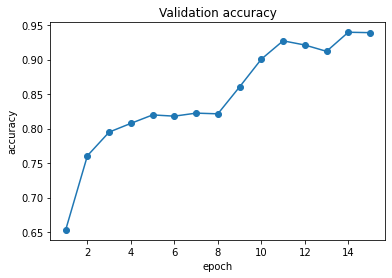

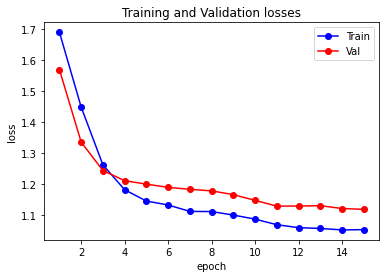

In [10]:
@torch.no_grad()
def eval(model, valloader):
    model.eval()
    results = [model.validate_step(batch) for batch in valloader]
    return model.validate_epoch(results)

def fit(epochs, learning_rate, model, trainloader, valloader, optimfunc):
    history = []
    optimizer = optimfunc(model.parameters(), learning_rate)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in trainloader:
            loss = model.train_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = eval(model, valloader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

model = to_device(ResNet50(), device)
print(eval(model, val_dataloader))

epochs = 15
optimizer = torch.optim.Adam
learning_rate = 1e-5

train_history = fit(epochs, learning_rate, model, train_dataloader, val_dataloader, optimizer)

def plot_acc_history(history):
    epoch_axis = np.arange(1, epochs + 1)
    acc = [i['val_acc'] for i in history]
    plt.plot(epoch_axis, acc, '-o')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Validation accuracy')
    plt.show()
plot_acc_history(train_history)

def plot_loss_history(history):
    epoch_axis = np.arange(1, epochs + 1)
    train_losses = [i['train_loss'] for i in history]
    val_losses = [i['val_loss'] for i in history]
    plt.plot(epoch_axis, train_losses, '-bo')
    plt.plot(epoch_axis, val_losses, '-ro')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Train', 'Val'])
    plt.title('Training and Validation losses')
    plt.show()
plot_loss_history(train_history)

Обученную модель я применю для распознавания тестовой (заранее отложенной) выборки.

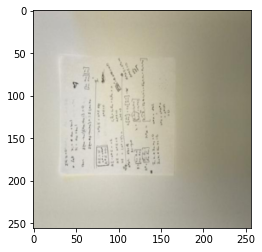

True: paper
Predicted:
paper with probability 0.999833345413208


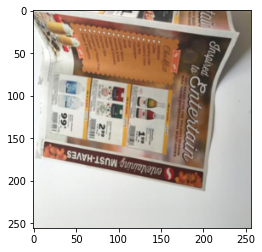

True: paper
Predicted:
paper with probability 0.9998754262924194


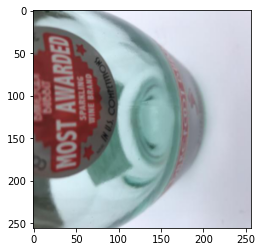

True glass
Predicted:
glass with probability 0.9084669947624207


In [11]:
def predict_img(model, img):
    x = to_device(img.unsqueeze(0), device)
    y = model(x)
    probability, label = torch.max(y, dim=1)
    return data.classes[label.item()], probability.item()

img, label = test_data[10]
plt.imshow(img.permute(1, 2, 0))
plt.show()
print('True:', data.classes[label])
res = predict_img(model, img)
print('Predicted:')
print(str(res[0]) + ' with probability ' + str(res[1]))

img, label = test_data[20]
plt.imshow(img.permute(1, 2, 0))
plt.show()
print('True:', data.classes[label])
res = predict_img(model, img)
print('Predicted:')
print(str(res[0]) + ' with probability ' + str(res[1]))

img, label = test_data[30]
plt.imshow(img.permute(1, 2, 0))
plt.show()
print('True', data.classes[label])
res = predict_img(model, img)
print('Predicted:')
print(str(res[0]) + ' with probability ' + str(res[1]))